# Prepare environment

In [36]:
import torch

from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from dataset.dataset_type import DatasetType
from dataset.dataset_info import ClassifierDatasetInfo
from dataset.STARCOP_dataset import STARCOPDataset
from models.Tools.Measures.model_type import ModelType
from models.Tools.Measures.measure_tool_factory import MeasureToolFactory
from models.Tools.FilesHandler.model_files_handler import ModelFilesHandler
from models.Convolutional.MethaNet.model import MethaNetClassifier

import os
os.chdir(r"D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load sample images

In [37]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=False)

# Visualize inputs

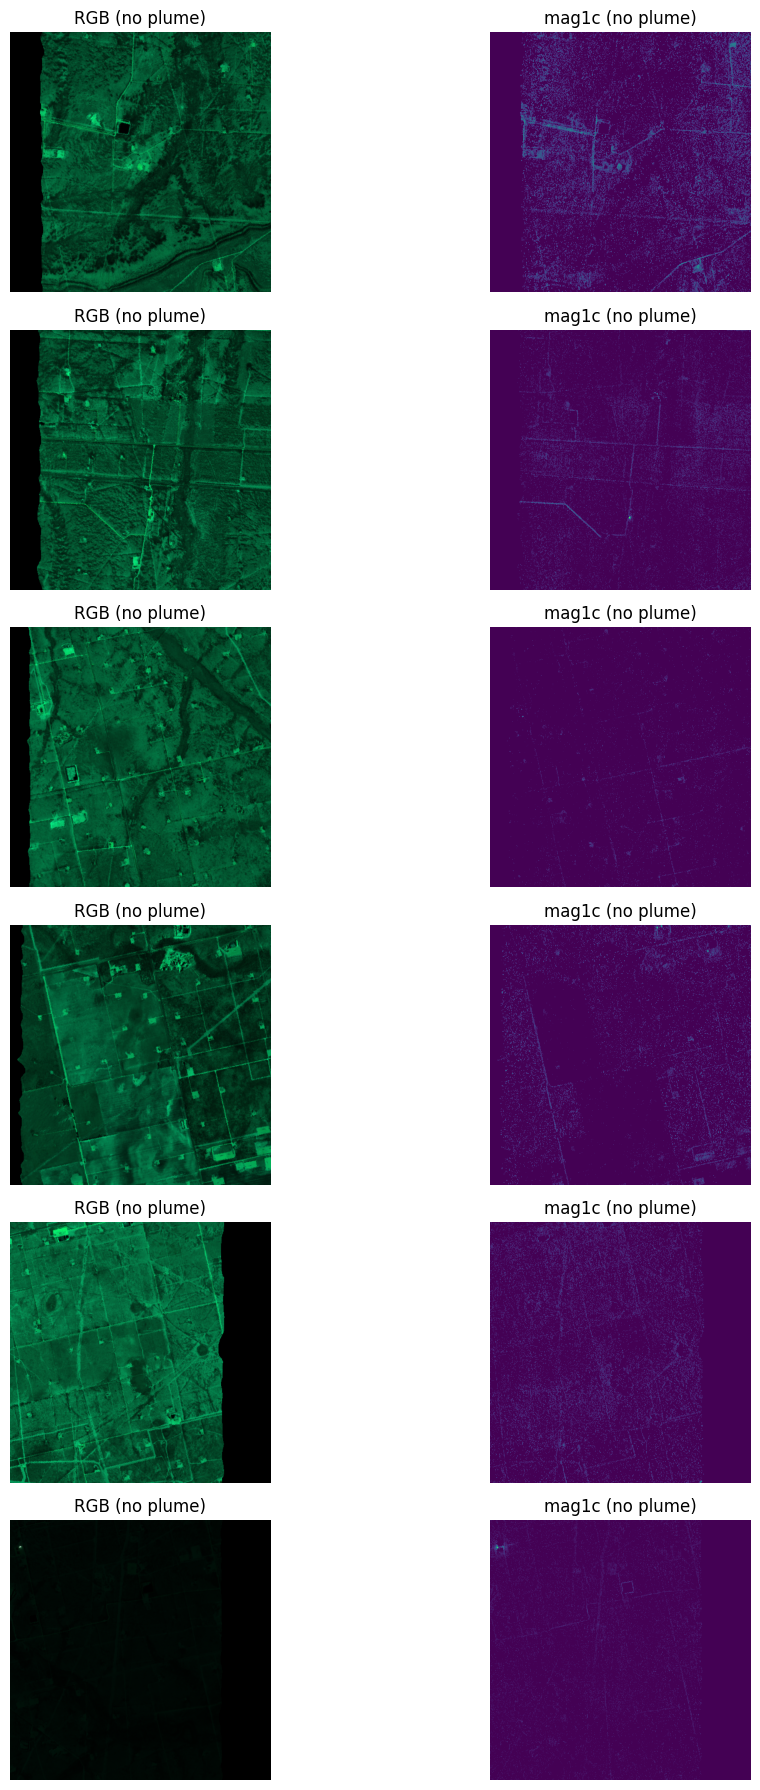

In [38]:
images = next(iter(dataloader))

# Create a figure with subplots
fig, ax = plt.subplots(6, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
for i in range(images[0].shape[0]):
    image_rgb = images[0][i, :3, :, :].permute(1, 2, 0).numpy()
    image_mag1c = images[1][i].squeeze(0).numpy()

    image_rgb = image_rgb - image_rgb.min()  # Shift minimum to 0
    image_rgb = image_rgb / image_rgb.max()  # Scale maximum to 1

    plume = images[2][i].item()
    ax[i, 0].imshow(image_rgb)
    ax[i, 0].set_title(f"RGB ({"plume" if plume == True else "no plume"})")
    ax[i, 0].axis('off')

    # Display the second image
    ax[i, 1].imshow(image_mag1c)  # Automatically handles RGB
    ax[i, 1].set_title(f"mag1c ({"plume" if plume == True else "no plume"})")
    ax[i, 1].axis('off')  # Turn off axis

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

# Prepare model

In [39]:
from models.Tools.Measures.model_type import ModelType
from models.Tools.Measures.measure_tool_factory import MeasureToolFactory

file_name = r"best_models\CNN\model_cnn_2024_12_14_13_20_07.pickle"

criterion = nn.CrossEntropyLoss()
measurer = MeasureToolFactory.get_measure_tool(ModelType.CNN)
model_handler = ModelFilesHandler()
model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

MethaNetClassifier(
  (pre_conv): Sequential(
    (0): Conv2d(9, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 16, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=59536, out_features=64, bias=True)
    (2): ReLU()
    (3):

# Show performance

In [40]:
all_predictions = []
all_labels = []
running_loss = 0.0

for batch_id, (images, mag1c, labels) in enumerate(dataloader):
    input_image = torch.cat((images, mag1c), dim=1).to(device)
    labels = labels.long().to(device)

    outputs = model(input_image)
    predictions = torch.argmax(outputs, dim=1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    all_predictions.append(predictions.cpu().detach())
    all_labels.append(labels.cpu().detach())

all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)

measures = measurer.compute_measures(all_predictions, all_labels)
print(f"Validation loss: {running_loss / len(dataloader)}.\nMeasures:\n{measures}")

Validation loss: 0.34396546765377645.
Measures:
        TP        FP        FN   TN  Precision  Sensitivity  Specificity  \
0  0.47076  0.011696  0.017544  0.5   0.975758     0.964072     0.977143   

        NPV       FPR  Accuracy  F-Score      IoU       MCC       AUC  \
0  0.966102  0.022857   0.97076  0.96988  0.94152  0.941537  0.970607   

         CI  
0  0.053037  


# Save model outputs

In [41]:
# predictions_path = r"best_models\CNN\predictions.txt"
# with open(predictions_path, "w") as file:
#     file.write(','.join(str(x) for x in all_predictions.tolist()))
#
# labels_path = r"best_models\CNN\labels.txt"
# with open(labels_path, "w") as file:
#     file.write(','.join(str(x) for x in all_labels.tolist()))